# Heart Failure Prediction #
* 11 features
* Output class: HeartDisease (0 for normal, 1 for heart disease)
* link to dataset: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

In [2]:
heart_data = pd.read_csv("/Users/brandonwu/Downloads/heart.csv")

print("DATASET FEATURES:")
for feature in heart_data.columns:
    print(f"{feature}, {heart_data[feature].dtype}")

print()
print("NUMBER OF NaN VALUES:")
for feature in heart_data.columns:
    print(f"NaN Values for {feature}: {heart_data[feature].isna().sum()}")

DATASET FEATURES:
Age, int64
Sex, object
ChestPainType, object
RestingBP, int64
Cholesterol, int64
FastingBS, int64
RestingECG, object
MaxHR, int64
ExerciseAngina, object
Oldpeak, float64
ST_Slope, object
HeartDisease, int64

NUMBER OF NaN VALUES:
NaN Values for Age: 0
NaN Values for Sex: 0
NaN Values for ChestPainType: 0
NaN Values for RestingBP: 0
NaN Values for Cholesterol: 0
NaN Values for FastingBS: 0
NaN Values for RestingECG: 0
NaN Values for MaxHR: 0
NaN Values for ExerciseAngina: 0
NaN Values for Oldpeak: 0
NaN Values for ST_Slope: 0
NaN Values for HeartDisease: 0


### Exploratory Data Analysis

In [3]:
print("GENERAL SUMMARY:")
print(heart_data.describe())

GENERAL SUMMARY:
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.600000      1.000000  
75%      1.500000      1.000000  
max      6.200000      1.000000  


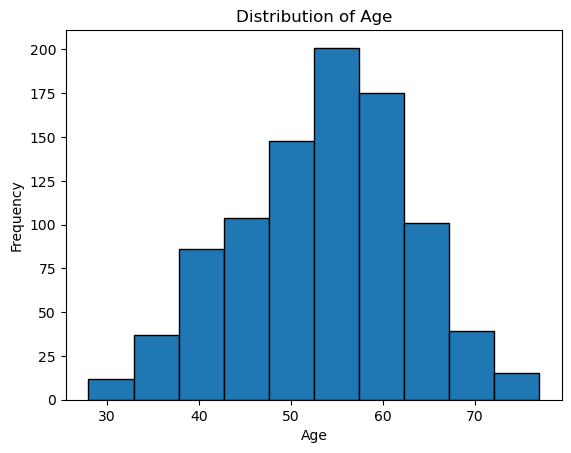

AGE SKEWNESS: -0.19593302867569365


In [4]:
fig, axes = plt.subplots()
plt.hist(heart_data["Age"], edgecolor="black")
plt.title(f"Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

print(f"AGE SKEWNESS: {heart_data['Age'].skew()}")

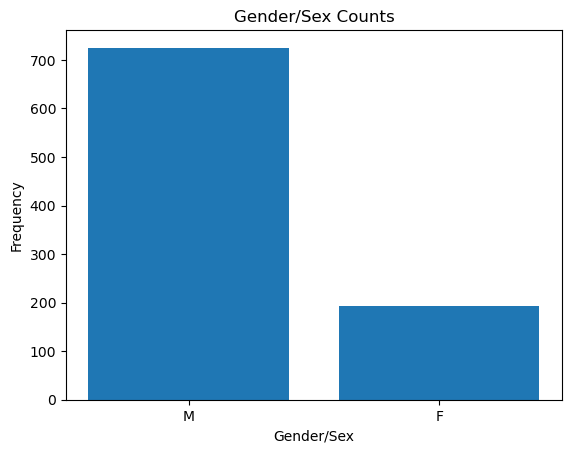

In [5]:
gender_counts = Counter(heart_data["Sex"])

plt.bar(gender_counts.keys(), gender_counts.values())
plt.xlabel("Gender/Sex")
plt.ylabel("Frequency")
plt.title("Gender/Sex Counts")
plt.show()

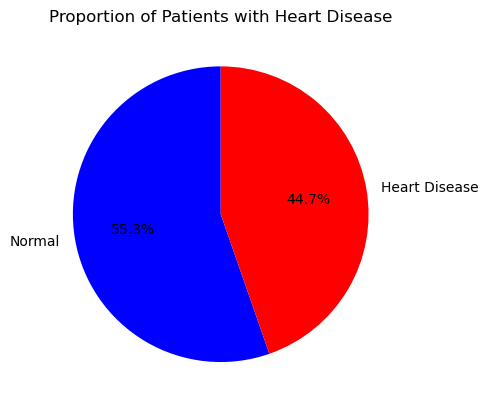

In [6]:
fig, axes = plt.subplots()

heart_disease_counts = heart_data["HeartDisease"].value_counts()
plt.pie(heart_disease_counts, labels=["Normal", "Heart Disease"], autopct='%1.1f%%', startangle=90, colors=["blue", "red"])
plt.title("Proportion of Patients with Heart Disease")
plt.show()

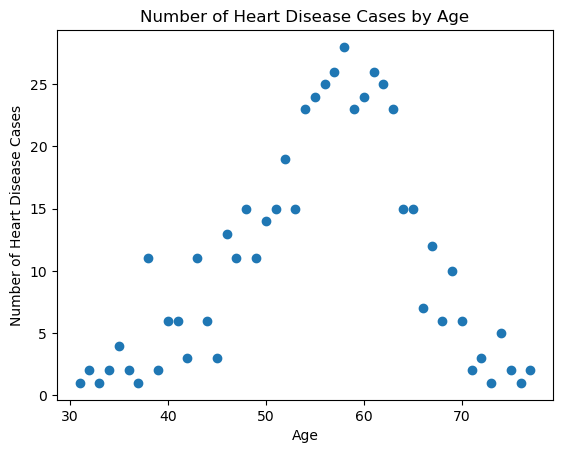

In [7]:
hd_cases = heart_data[heart_data["HeartDisease"] == 1]
hd_counts = Counter(hd_cases["Age"])

plt.scatter(hd_counts.keys(), hd_counts.values())
plt.xlabel("Age")
plt.ylabel("Number of Heart Disease Cases")
plt.title("Number of Heart Disease Cases by Age")
plt.show()

### Number of Heart Disease Cases by Age
- People in the 50 - 60 age group contribute to the most heart disease cases
- The number of cases in the 30 - 40 and 60 - 70 age group is noticeably lower compared to the 50 - 60 age group

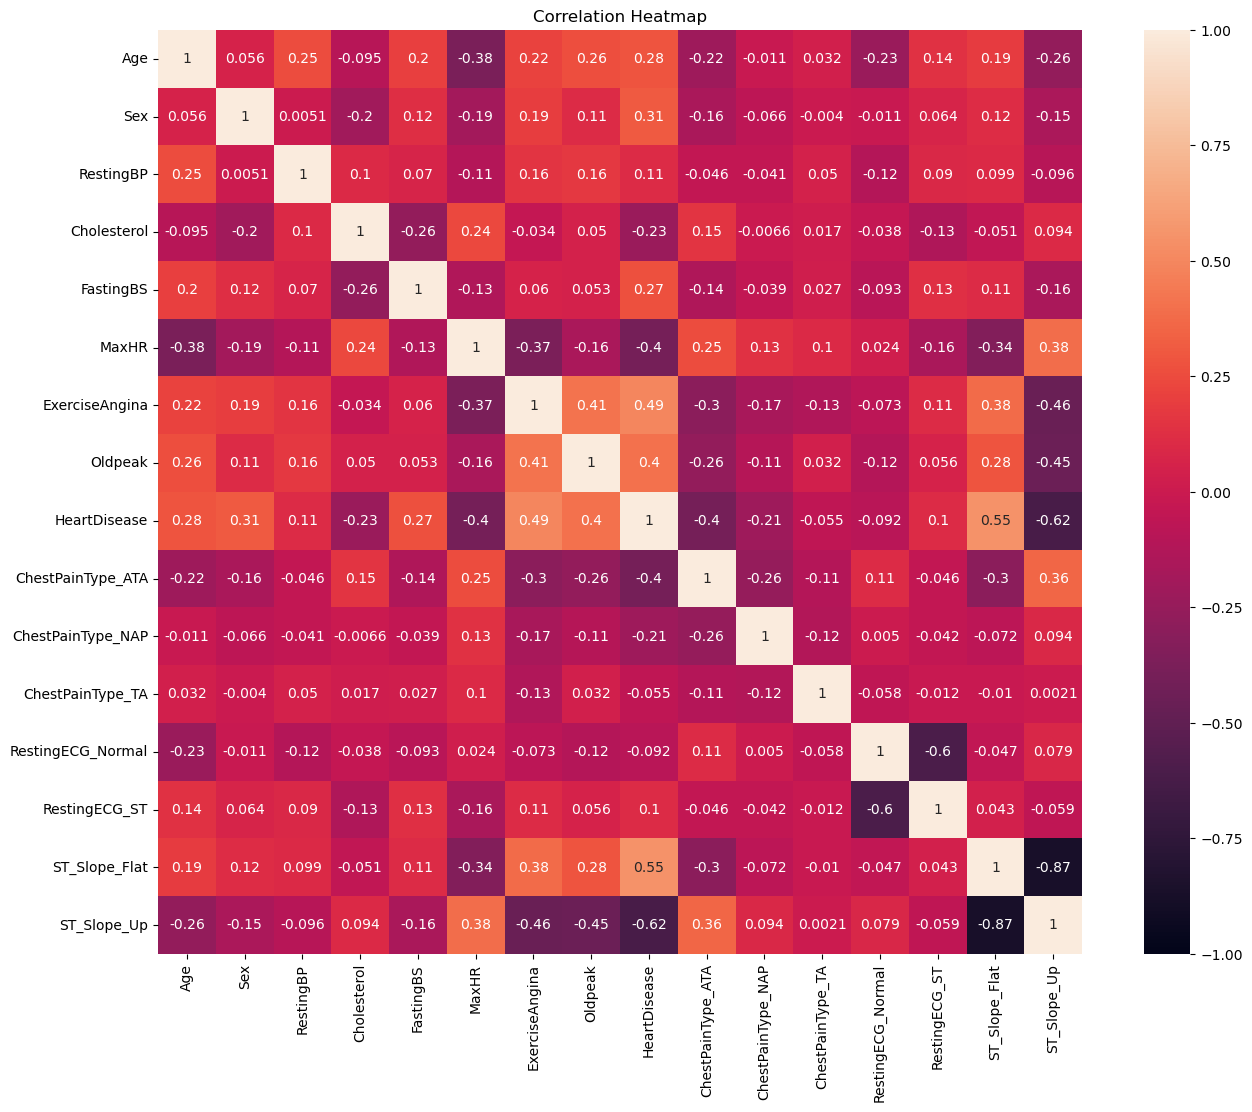

In [8]:
# Non-numerical features: Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope
heart_data["Sex"] = heart_data["Sex"].map({"M": 1, "F": 0})
heart_data["ExerciseAngina"] = heart_data["ExerciseAngina"].map({"Y": 1, "N": 0})
heart_data = pd.get_dummies(heart_data, columns=["ChestPainType", "RestingECG", "ST_Slope"], drop_first=True)
corr_matrix = heart_data.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap")
plt.show()

### Fitting a Logistic Regression Model

In [9]:
X = heart_data.drop(columns=["HeartDisease"])
y = heart_data["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

learner = LogisticRegression()
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)

print(f"TEST ERROR RATE FOR INTIAL LOGISTIC REGRESSION: {1 - accuracy_score(y_test, y_pred)}")
print()
print(f"CLASSIFICATION REPORT FOR INITIAL LOGISTIC REGRESSION:")
print(classification_report(y_test, y_pred))

TEST ERROR RATE FOR INTIAL LOGISTIC REGRESSION: 0.1467391304347826

CLASSIFICATION REPORT FOR INITIAL LOGISTIC REGRESSION:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



### Fine Tuning Features for Logistic Regression Model

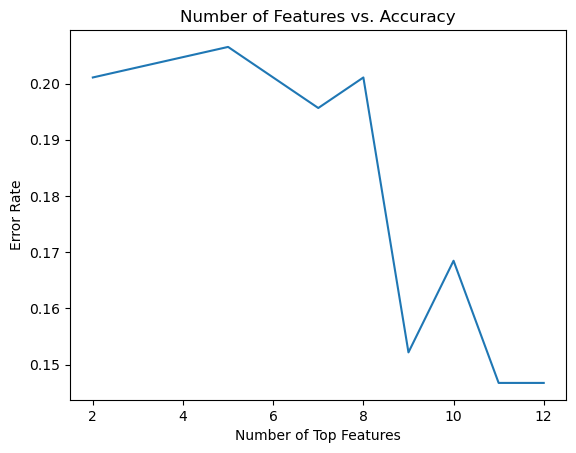

In [10]:
num_features = [2, 5, 7, 8, 9, 10, 11, 12]
accuracy_scores = []

for num in num_features:
    selector = SelectKBest(f_classif, k=num)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    learner = LogisticRegression()
    learner.fit(X_train_selected, y_train)
    y_pred = learner.predict(X_test_selected)
    error_rate = 1 - accuracy_score(y_test, y_pred)
    accuracy_scores.append(error_rate)

plt.plot(num_features, accuracy_scores)
plt.xlabel("Number of Top Features")
plt.ylabel("Error Rate")
plt.title("Number of Features vs. Accuracy")
plt.show()


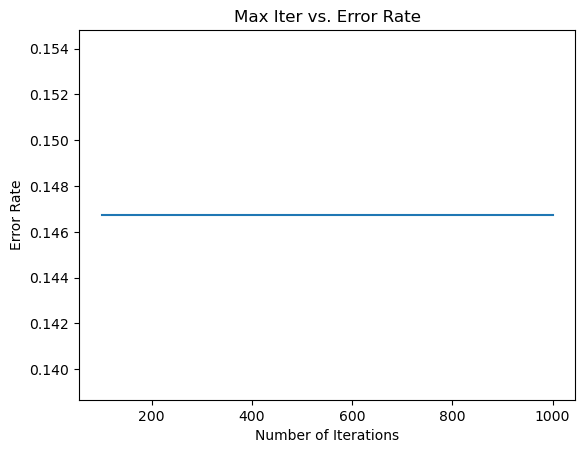

In [11]:
max_iters = [100, 200, 500, 750, 1000]
error_rates = []

for num in max_iters:
    learner = LogisticRegression(max_iter=num)
    learner.fit(X_train, y_train)
    y_pred = learner.predict(X_test)
    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

plt.plot(max_iters, error_rates)
plt.xlabel("Number of Iterations")
plt.ylabel("Error Rate")
plt.title("Max Iter vs. Error Rate")
plt.show()


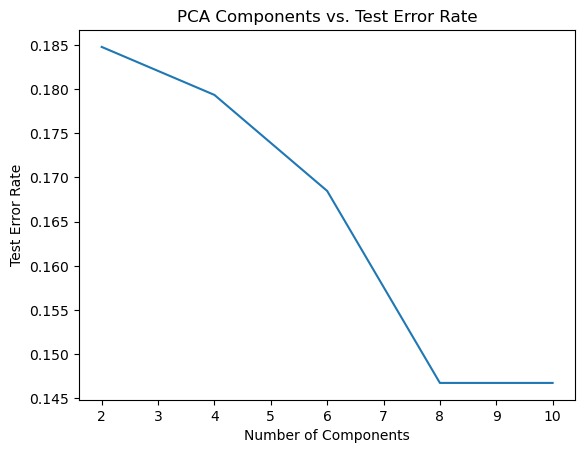

In [12]:
num_components = [2, 4, 6, 8, 10]
error_rates = []

for num in num_components:
    pca = PCA(n_components=num)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    learner = LogisticRegression()
    learner.fit(X_train_pca, y_train)
    y_pred = learner.predict(X_test_pca)

    error_rate = 1 - accuracy_score(y_test, y_pred)
    error_rates.append(error_rate)

plt.plot(num_components, error_rates)
plt.xlabel("Number of Components")
plt.ylabel("Test Error Rate")
plt.title("PCA Components vs. Test Error Rate")
plt.show()

### Trying to Model Quadratic Relationship Between Age and Heart Disease

In [13]:
poly = PolynomialFeatures(degree=2, include_bias=False)
age_poly = poly.fit_transform(heart_data[["Age"]])
heart_data["age_squared"] = age_poly[:, 1]

learner = LogisticRegression(max_iter=1000)
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)

print(f"TEST ERROR RATE FOR INTERACTION TERM LOGISTIC REGRESSION: {1 - accuracy_score(y_test, y_pred)}")
print()
print(f"CLASSIFICATION REPORT FOR INTERACTION TERM LOGISTIC REGRESSION:")
print(classification_report(y_test, y_pred))
heart_data = heart_data.drop("age_squared", axis=1)

TEST ERROR RATE FOR INTERACTION TERM LOGISTIC REGRESSION: 0.1467391304347826

CLASSIFICATION REPORT FOR INTERACTION TERM LOGISTIC REGRESSION:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



In [14]:
logistic_regression_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],  
    'penalty': ['l1', 'l2'],  
    'max_iter': [1000, 2000, 3000],  
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

learner = LogisticRegression()
grid_search = GridSearchCV(learner, logistic_regression_params, cv=5, scoring="accuracy")

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_lr_model = grid_search.best_estimator_

y_pred = best_lr_model.predict(X_test_scaled)
print(f"TEST ERROR RATE FOR BEST_LR_MODEL: {1 - accuracy_score(y_test, y_pred)}")
print()
print("CLASSIFICATION REPORT FOR BEST_LR_MODEL:")
print(classification_report(y_test, y_pred))

TEST ERROR RATE FOR BEST_LR_MODEL: 0.1467391304347826

CLASSIFICATION REPORT FOR BEST_LR_MODEL:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



### Results of Logistic Regression
- Feature engineering did not seem to improve the model's predicting power.
- Introducing a polynomial term age_squared made the model's performance worse.

### Fitting an XGB Classifier 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

learner = XGBClassifier()
learner.fit(X_train, y_train)

y_pred = learner.predict(X_test)

print(f"TEST ERROR RATE FOR XGBCLASSIFIER: {1 - accuracy_score(y_test, y_pred)}")
print()
print(f"CLASSIFICATION REPORT FOR XGBCLASSIFIER:")
print(classification_report(y_test, y_pred))

TEST ERROR RATE FOR XGBCLASSIFIER: 0.13586956521739135

CLASSIFICATION REPORT FOR XGBCLASSIFIER:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        77
           1       0.89      0.87      0.88       107

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184



In [16]:
XGB_param_grid = {
    "n_estimators": [10, 20, 50, 100, 200],
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 5, 7, 10, 15],
    "gamma": [0, 0.1, 0.2, 0.5],
    "reg_alpha": [0, 0.01, 0.1, 1],  
    "reg_lambda": [0, 0.01, 0.1, 1]  
}

learner = XGBClassifier()
grid_search = GridSearchCV(learner, XGB_param_grid, cv=5, scoring="accuracy")

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

y_pred = best_xgb_model.predict(X_test)
print(f"TEST ERROR RATE FOR BEST_XGB_MODEL: {1 - accuracy_score(y_test, y_pred)}")
print()
print("CLASSIFICATION REPORT FOR BEST XGB_MODEL:")
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

### Fitting a Random Forest Classifier

In [ ]:
learner = RandomForestClassifier()
learner.fit(X_train, y_train)
y_pred = learner.predict(X_test)

print(f"TEST ERROR RATE FOR INITIAL RANDOM FOREST MODEL: {1 - accuracy_score(y_test, y_pred)}")
print()
print("CLASSIFICATION REPORT FOR INTIAL RANDOM FOREST MODEL:")
print(classification_report(y_test, y_pred))

TEST ERROR RATE FOR INITIAL RANDOM FOREST MODEL: 0.125

CLASSIFICATION REPORT FOR INTIAL RANDOM FOREST MODEL:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



In [ ]:
random_forest_param_grid = {
    "n_estimators": [25, 50, 75, 100],
    "max_depth": [10, 20, 30, 40, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5],
    "bootstrap": [True, False]
}

learner = RandomForestClassifier()
grid_search = GridSearchCV(learner, random_forest_param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

best_rf_model.fit(X_train, y_train)

print(f"TEST ERROR RATE FOR BEST_RF_MODEL: {1 - accuracy_score(y_test, y_pred)}")
print()
print("CLASSIFICATION REPORT FOR BEST_RF_MODEL:")
print(classification_report(y_test, y_pred))

TEST ERROR RATE FOR BEST_RF_MODEL: 0.125

CLASSIFICATION REPORT FOR BEST_RF_MODEL:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



### Fitting an SVC Model

In [ ]:
learner = SVC()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svc_param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

grid_search = GridSearchCV(learner, svc_param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_svc_model = grid_search.best_estimator_

best_svc_model.fit(X_train_scaled, y_train)
y_pred = best_svc_model.predict(X_test_scaled)
print(f"TEST ERROR RATE FOR BEST_SVC_MODEL: {1 - accuracy_score(y_test, y_pred)}")
print()
print("CLASSIFICATION REPORT FOR BEST_SVC_MODEL:")
print(classification_report(y_test, y_pred))

TEST ERROR RATE FOR BEST_SVC_MODEL: 0.14130434782608692

CLASSIFICATION REPORT FOR BEST_SVC_MODEL:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        77
           1       0.90      0.85      0.88       107

    accuracy                           0.86       184
   macro avg       0.85      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



In [ ]:
best_models = [("lr", best_lr_model), ("xgb", best_xgb_model), ("rf", best_rf_model), ("svc", best_svc_model)]
meta_learner = LogisticRegression()
combined_models = StackingClassifier(estimators=best_models, final_estimator=meta_learner)
combined_models.fit(X_train, y_train)
y_pred = combined_models.predict(X_test)

print(f"TEST ERROR RATE FOR COMBINED MODELS: {1 - accuracy_score(y_test, y_pred)}")
print()
print("CLASSIFICATION REPORT FOR COMBINED MODELS:")
print(classification_report(y_test, y_pred))

TEST ERROR RATE FOR COMBINED MODELS: 0.13043478260869568

CLASSIFICATION REPORT FOR COMBINED MODELS:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        77
           1       0.89      0.89      0.89       107

    accuracy                           0.87       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.87      0.87       184



In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(6, 24))
best_models = [best_lr_model, best_xgb_model, best_rf_model, best_svc_model]
class_labels = ["No Heart Disease", "Heart Disease"]

for i, learner in enumerate(best_models):
    y_pred = learner.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=axes[i])

plt.tight_layout()
plt.show()